In [1]:
cd ..

/master


In [2]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#%load_ext autoreload
#%autoreload 2
#%pdb

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(8)

Autosaving every 600 seconds


# (LARGE) Multihead Attn Contditional Neural Process 1D - Gaussian Process Samples

last update: 08 June 2019

**Aim**: This notebook shows how to train and sample from a Conditional Neural Process (no latents) for a simple class of 1D functions. The functions are sampled from a Gaussian process with various kernels.


In [3]:
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, ExpSineSquared, 
                                              DotProduct, ConstantKernel)

from skssl.transformers import NeuralProcessLoss, NeuralProcess, SelfAttentionEncoder, AttentiveNeuralProcess
from skssl.predefined import MLP
from skssl.transformers.neuralproc.datasplit import context_target_split

from ntbks_datasets import GPDataset
from ntbks_viz import plot_posterior_samples, plot_prior_samples, plot_dataset_samples

In [4]:
x_dim = 1
y_dim = 1
r_dim = 128
batch_size = 32
num_points = 128
num_samples = 100000
n_epochs = 30


def _DeepMLP(*args):
    return MLP(*args, hidden_size=r_dim, n_hidden_layers=3)


def get_cntxt_trgt(*args):
    return context_target_split(*args,
                                range_cntxts=(4, 50),
                                range_extra_trgts=(3, num_points-50))


def get_model(x_dim, y_dim):
    return AttentiveNeuralProcess(x_dim, y_dim,
                                  XEncoder=MLP,
                                 attention="multihead",
                                  encoded_path="deterministic",
                                 XYEncoder=_DeepMLP,
                                 Decoder=_DeepMLP,
                                 r_dim=r_dim,
                                 LatentEncoder=MLP,
                                 get_cntxt_trgt=get_cntxt_trgt)


data_models = dict()
data_models["rbf"] = (get_model(x_dim, y_dim),
                      GPDataset(kernel=1.0 * RBF(length_scale=1.0,
                                                 length_scale_bounds=(1e-1, 10.0)),
                                num_samples=num_samples,
                                num_points=num_points))
data_models["periodic"] = (get_model(x_dim, y_dim),
                           GPDataset(kernel=1.0 * ExpSineSquared(length_scale=1.0,
                                                                 periodicity=3.0,
                                                                 length_scale_bounds=(0.1, 10.0),
                                                                 periodicity_bounds=(1.0, 10.0)),
                                     num_samples=num_samples,
                                     num_points=num_points))
data_models["non-stationary"] = (get_model(x_dim, y_dim),
                                 GPDataset(kernel=(ConstantKernel(0.1, (0.01, 10.0)) *
                                                   (DotProduct(sigma_0=1.0,
                                                               sigma_0_bounds=(0.1, 10.0)) ** 2)),
                                           num_samples=num_samples,
                                           num_points=num_points))
data_models["matern"] = (get_model(x_dim, y_dim),
                         GPDataset(kernel=1.0 * Matern(length_scale=1.0,
                                                       length_scale_bounds=(1e-1, 10.0),
                                                       nu=1.5),
                                   num_samples=num_samples,
                                   num_points=num_points))

##  Data

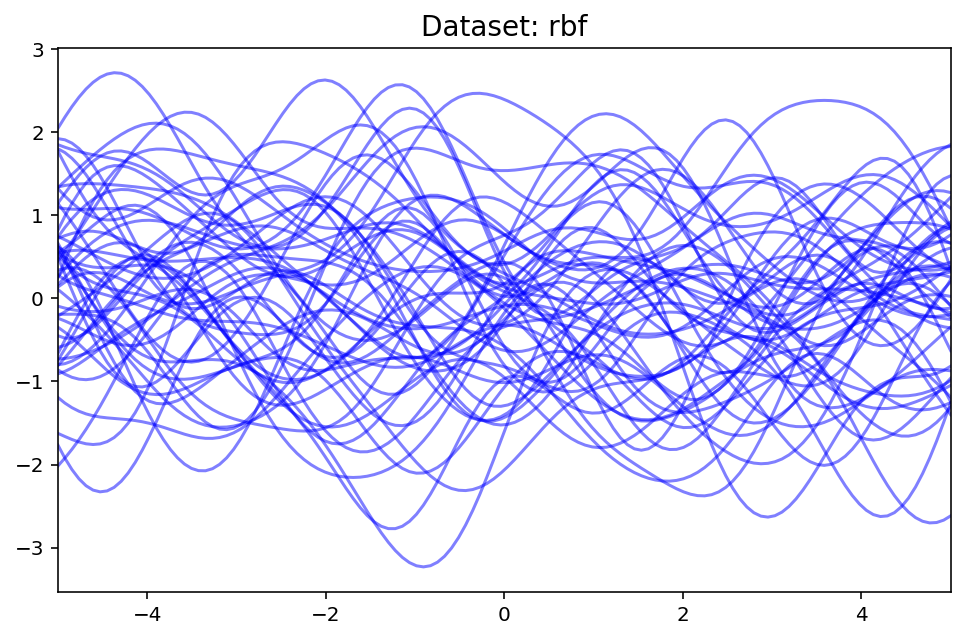

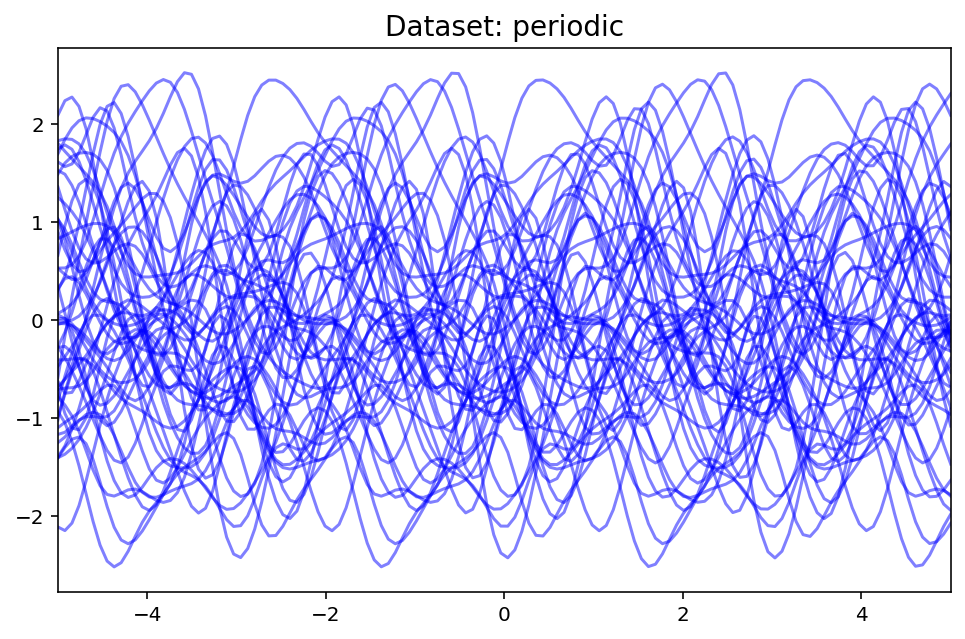

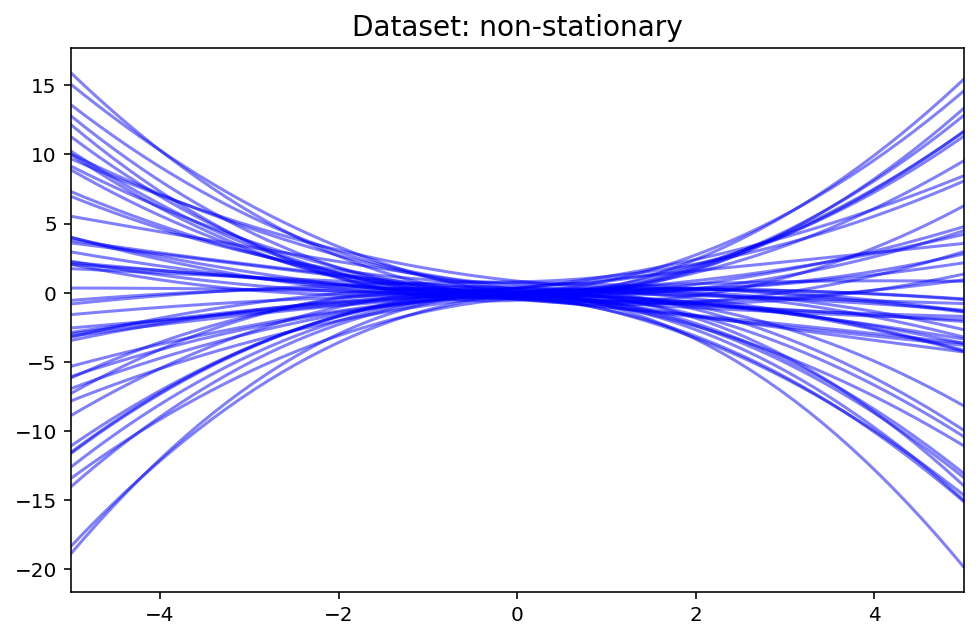

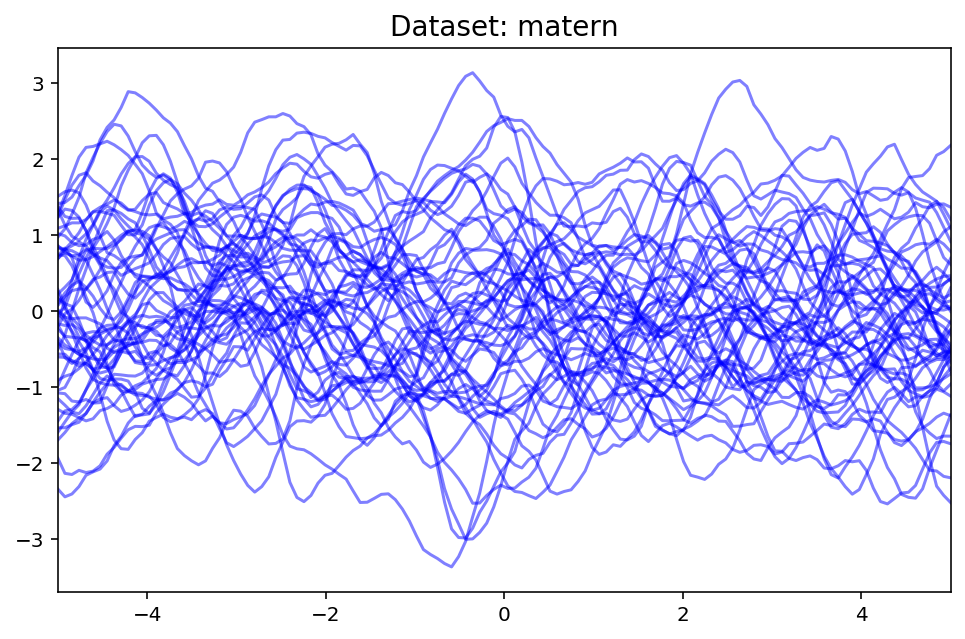

In [5]:
for k,(neural_proc, dataset) in data_models.items():
    plot_dataset_samples(dataset, title="Dataset: {}".format(k))

## Prior Samples

We can visualize the prior (i.e. the output of the neural process without any context points) before training.

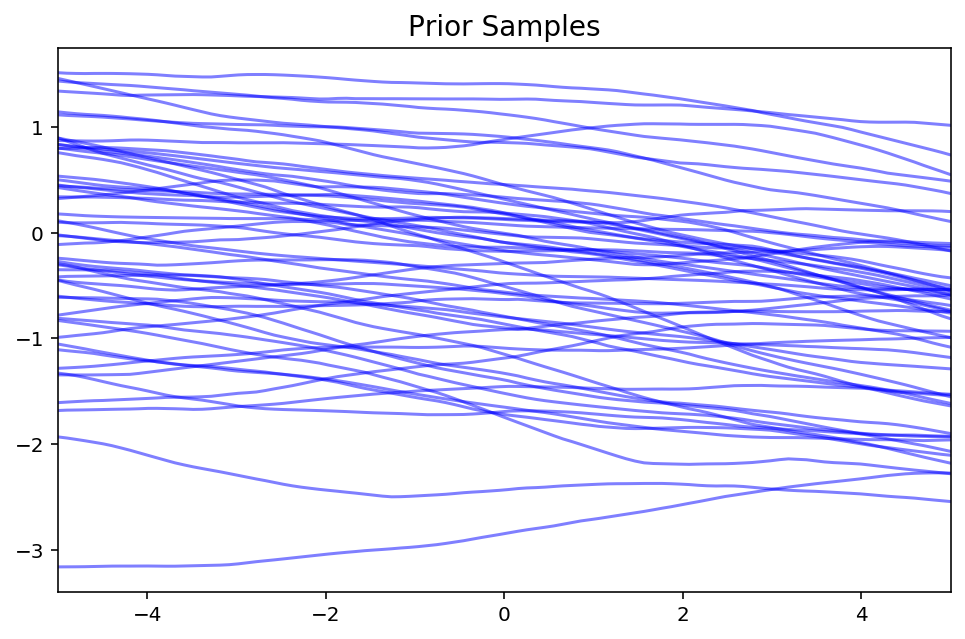

In [6]:
plot_prior_samples(neural_proc, r_dim, min_max=dataset.min_max)

## Training

In [7]:
from skssl.training import NeuralNetTransformer
from skssl.training.helpers import make_Xy_input

for k,(neural_proc, dataset) in data_models.items():
    print()
    print("--- Training {} ---".format(k))
    print()
    
    model = NeuralNetTransformer(neural_proc, NeuralProcessLoss,
                                 max_epochs=n_epochs,
                                 batch_size=batch_size,
                                 train_split=None,
                                 lr=1e-4) # no dev set
    
    _=model.fit(*make_Xy_input(dataset))


--- Training rbf ---



  epoch    train_loss      dur
-------  ------------  -------
      1     1144.3873  31.2199


      2      136.9646  25.1625


      3      127.2522  31.1070


      4       94.6063  29.7671


      5       79.2702  31.7710


      6       64.5120  24.6499


      7       50.1810  29.6760


      8       32.2601  28.1833


      9       12.0170  28.7357


     10       -7.6125  28.2505


     11      -25.1302  30.9557


     12      -41.6705  27.4915


     13      -58.1226  31.5718


     14      -65.7933  25.6838


     15      -77.0964  31.0551


     16      -82.9412  27.8210


     17      -88.0352  28.7522


     18      -93.9772  29.8264


     19      -98.4241  31.5100


     20     -102.2077  29.2839


     21     -100.0345  32.3085


     22     -103.8110  27.8249


     23     -105.9120  31.5940


     24      -81.3153  29.7022


     25     -107.5714  34.6794


     26     -109.7166  29.4373


     27     -108.0011  31.2104


     28     -111.4664  27.3950


     29     -110.4976  27.1114


     30     -115.6996  31.0056

--- Training periodic ---



  epoch    train_loss      dur
-------  ------------  -------
      1      505.1898  30.5847


      2      145.5328  29.0255


      3      137.7228  31.5557


      4      128.2992  31.1396


      5      114.7997  30.5908


      6      103.4504  32.6403


      7       96.1586  30.5374


      8       89.1440  30.4458


      9       82.6489  29.3607


     10       78.4182  30.6621


     11       73.6958  31.3997


     12       69.1568  31.2463


     13       62.3146  25.3472


     14       60.0503  29.9968


     15       54.0727  27.6109


     16       51.6255  32.0219


     17       47.6754  30.9102


     18       43.7494  31.9330


     19       38.6156  30.2687


     20       34.7703  29.0005


     21       36.2139  30.7426


     22       30.8310  30.5047


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



      7       -6.4715  30.2407


      8      -37.2550  25.4208


      9      -67.3072  30.5453


     10      -82.0834  30.8928


     11      -92.8859  30.5322


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     25     -138.0523  30.5428


     26     -139.0337  29.3431


     27     -138.2975  26.7884


     28     -140.8671  30.2424


     29     -142.2417  22.6373


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     14       -2.4762  30.6303


     15       -8.7788  29.1612


     16      -11.8206  30.3728


     17      -15.4633  30.8046


     18      -19.5705  30.7532


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Trained Prior 
The prior should now encode some information about the shapes of the functions.

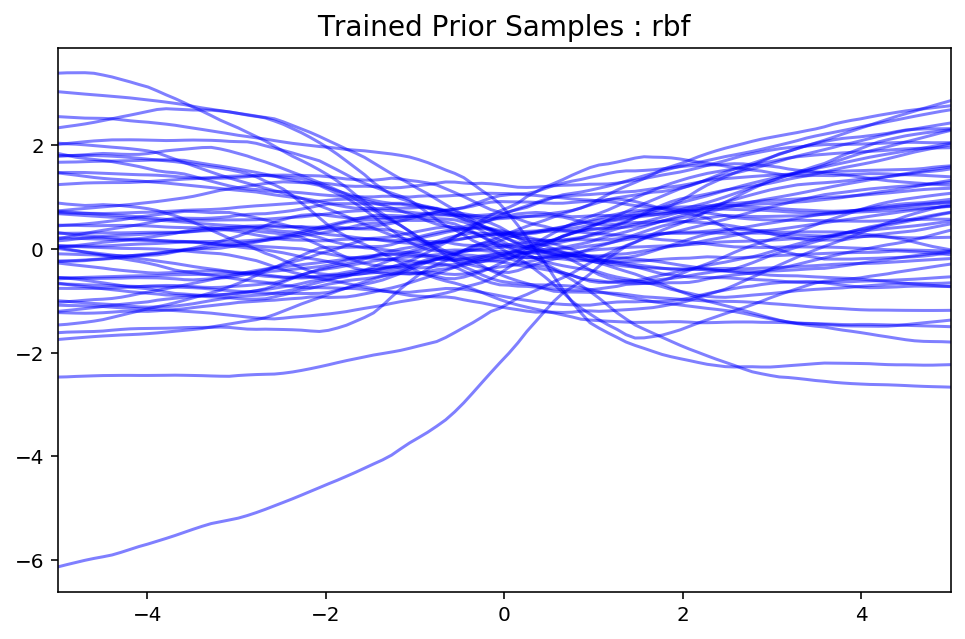

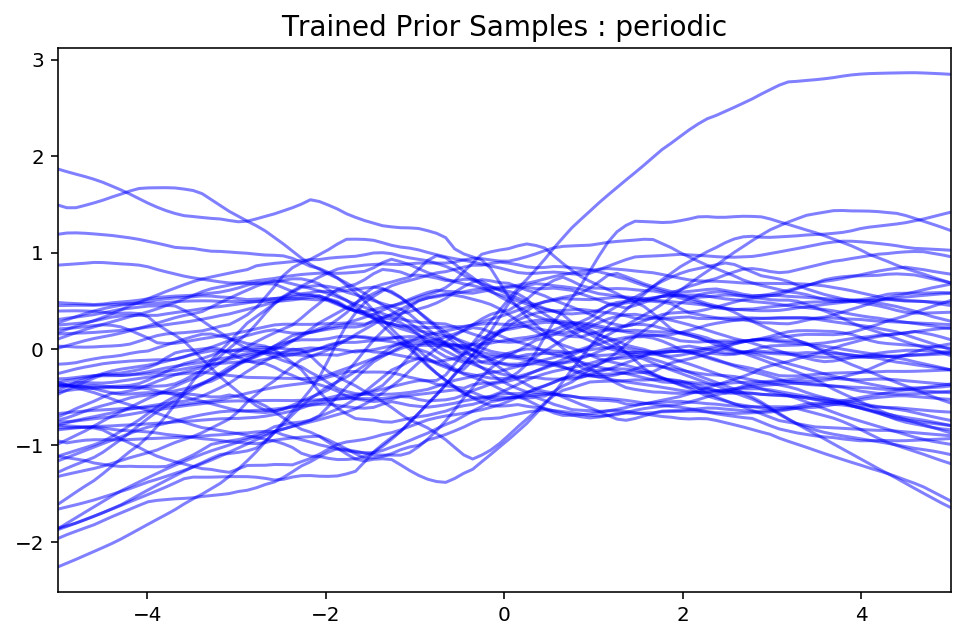

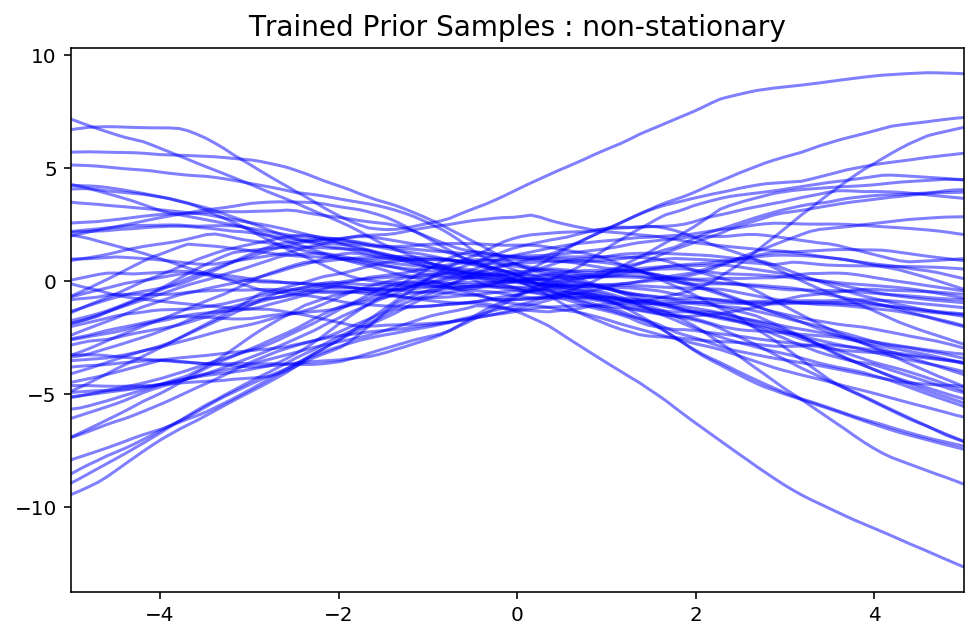

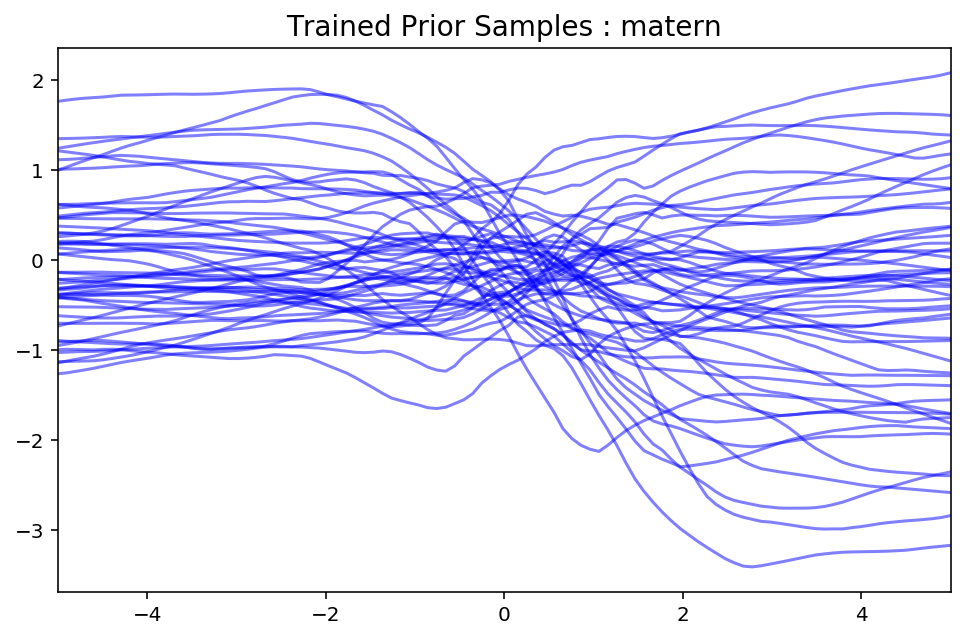

In [8]:
for k,(neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, r_dim, title="Trained Prior Samples : {}".format(k))

## Posterior

std: 0.1953096
std: 0.24403563
std: 0.20848209
std: 0.42333472


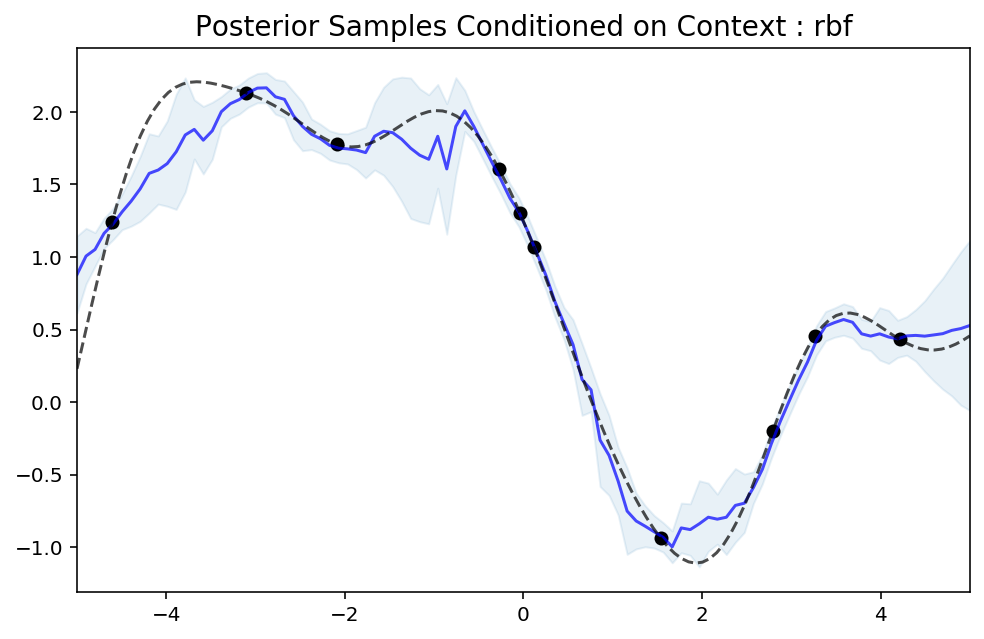

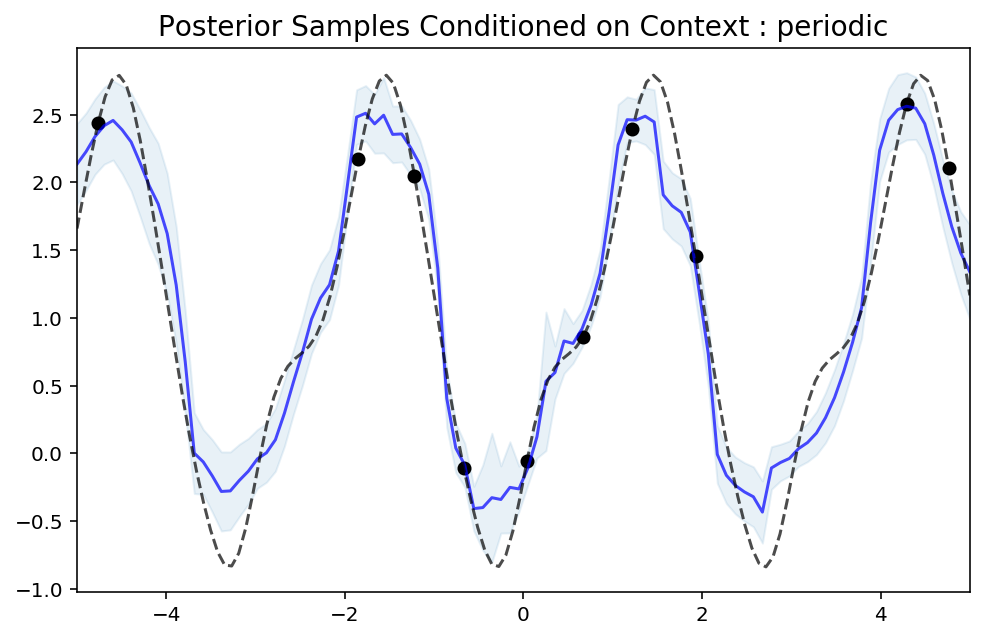

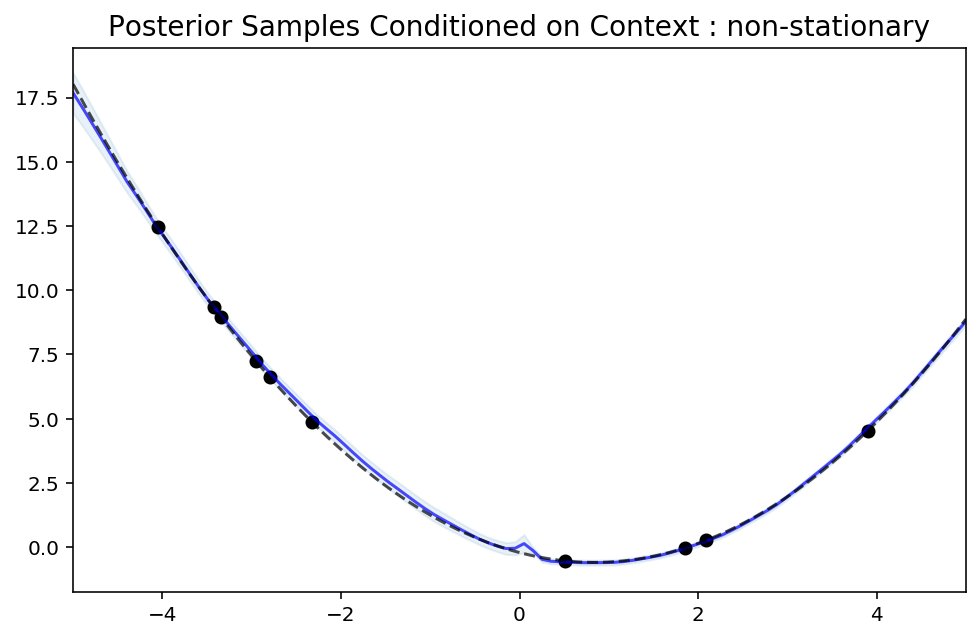

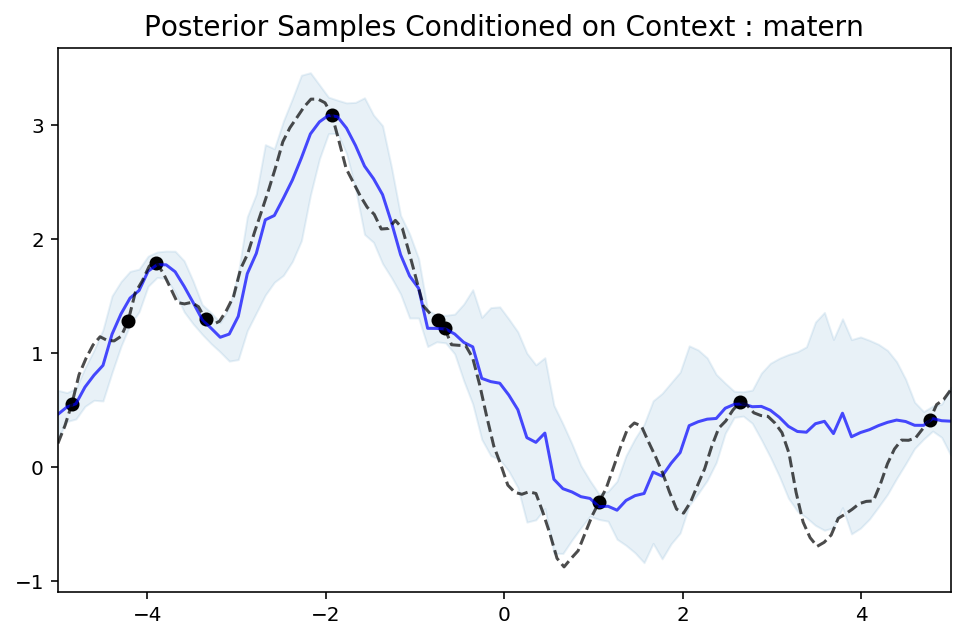

In [13]:
n_cntxt = 10

for k,(neural_proc, dataset) in data_models.items():
    
    for X, Y in model.get_iterator(dataset, training=False):
        break
    X, Y = X[0:1], Y[0:1]
    n_points = X.size(1)
    idx = torch.randperm(n_points)[:n_cntxt]
    X_cntxt, Y_cntxt = X[:,idx,:], Y[:,idx,:]
    
    
    plot_posterior_samples(neural_proc, X_cntxt, Y_cntxt, true_func=(X,Y),  is_plot_std=True, n_samples=1,
                           title="Posterior Samples Conditioned on Context : {}".format(k))

Let's now use a single context point to see how much information is in the "learned implicit kernel"

std: 0.83737856
std: 1.1365606
std: 1.6822968
std: 0.8843373


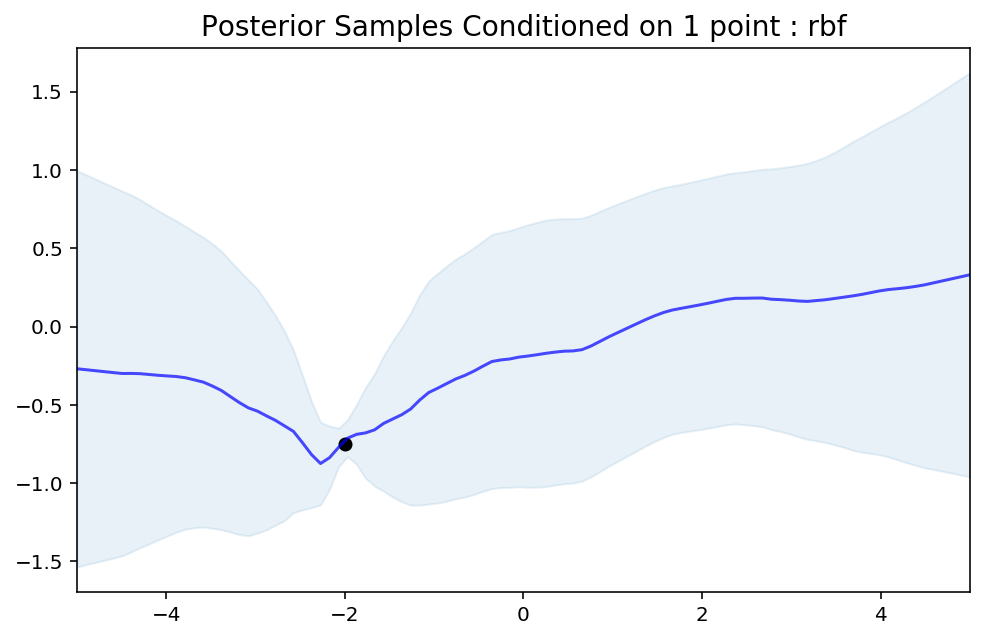

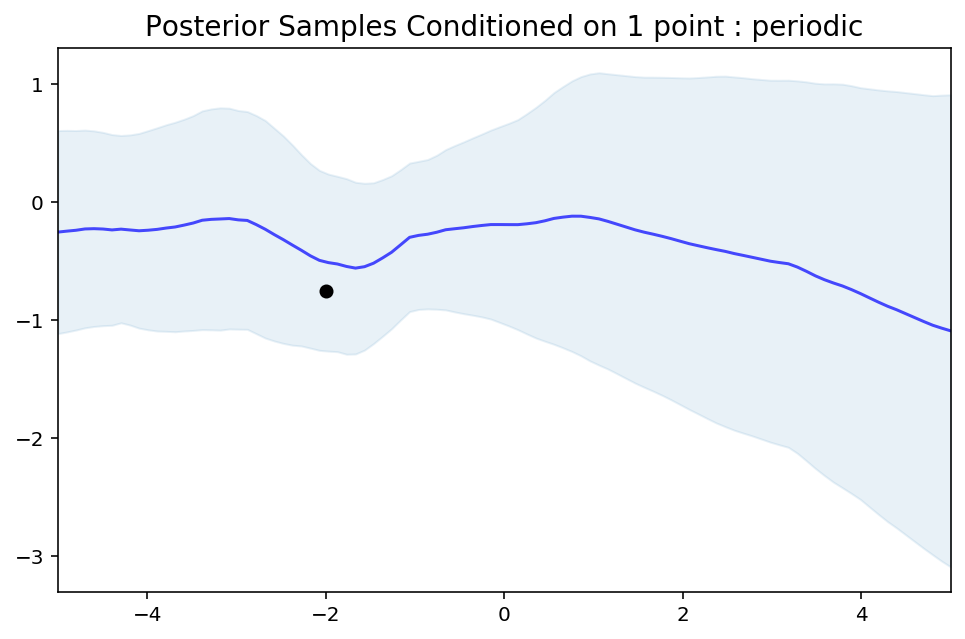

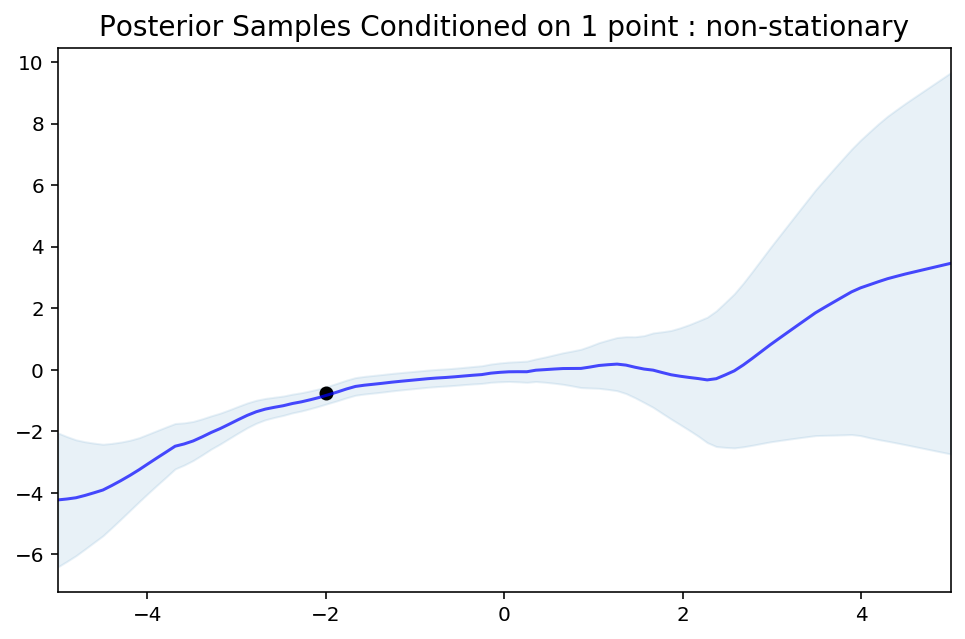

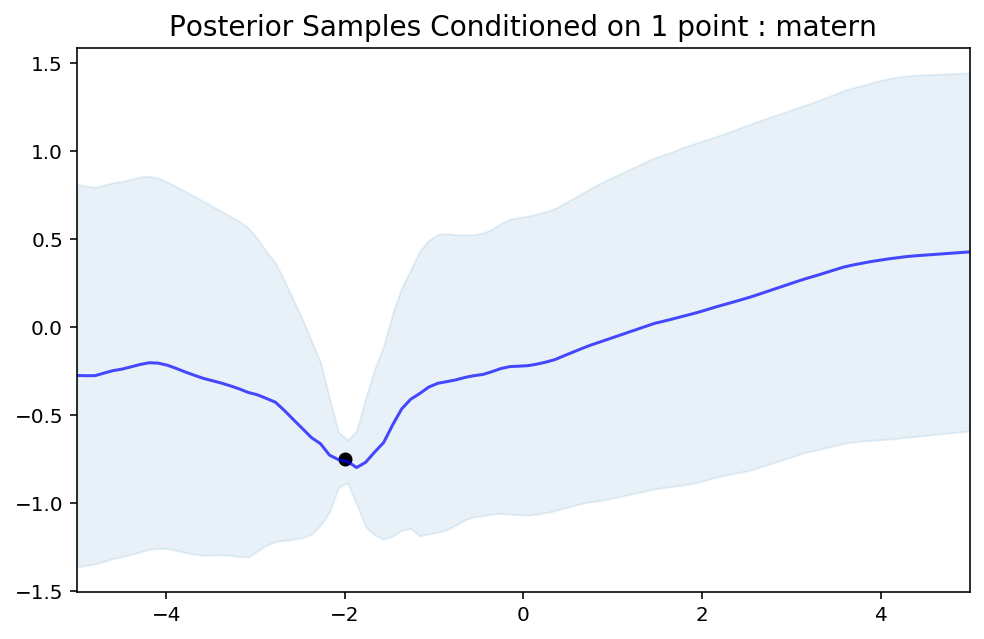

In [10]:
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(neural_proc, torch.tensor([[[-2.]]]), torch.tensor([[[-0.75]]]),  
                           is_plot_std=True, n_samples=1,
                           title="Posterior Samples Conditioned on 1 point : {}".format(k))

std: 0.8249598
std: 1.1742607
std: 1.9602401
std: 0.8345234


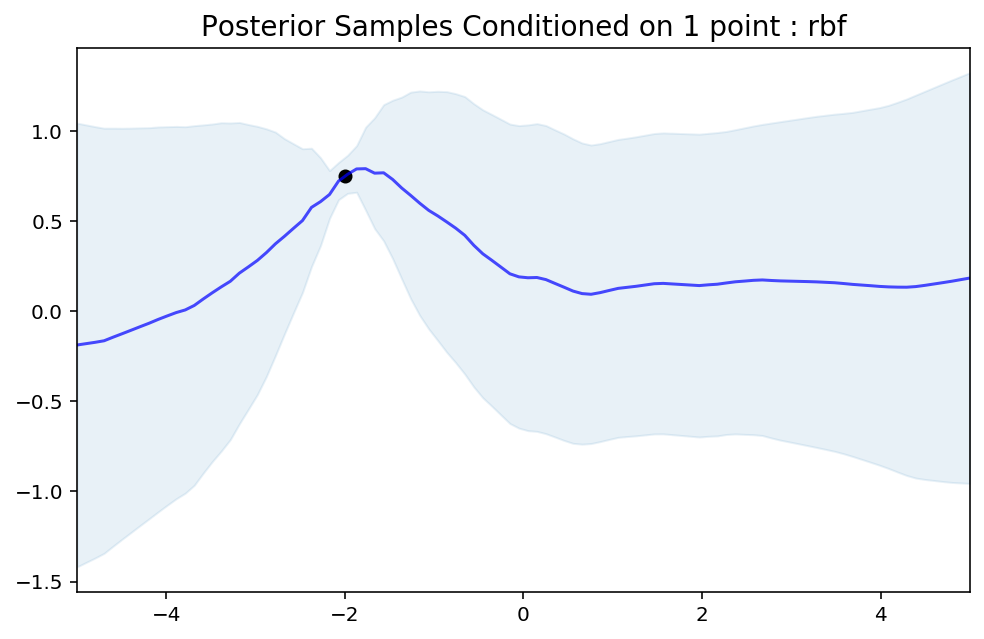

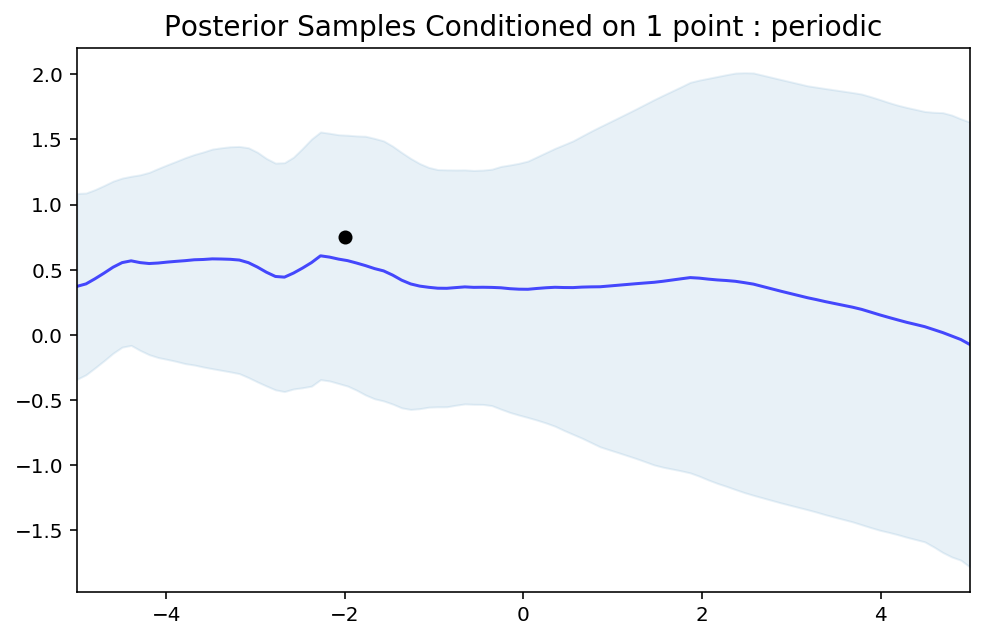

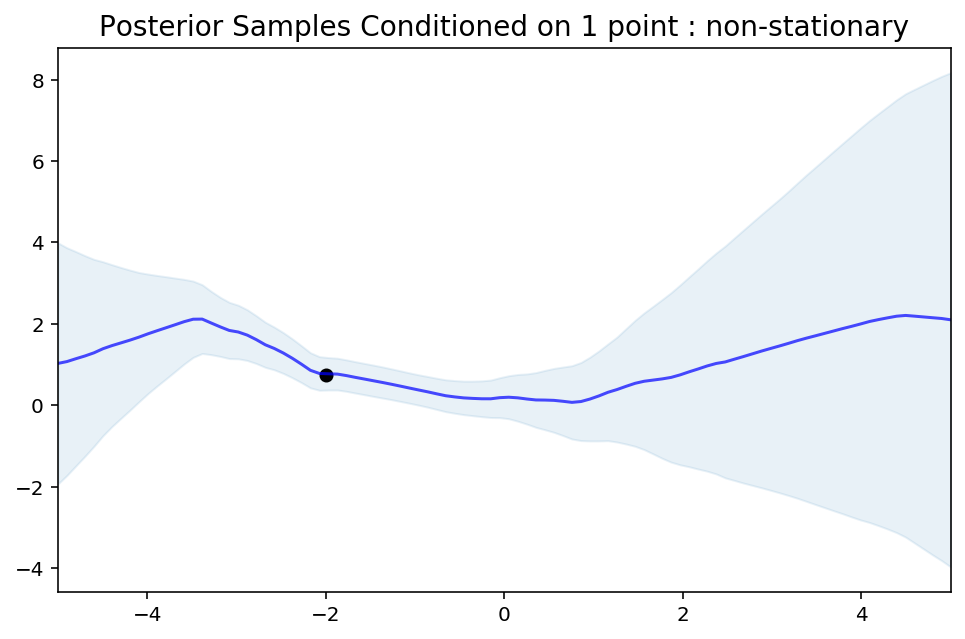

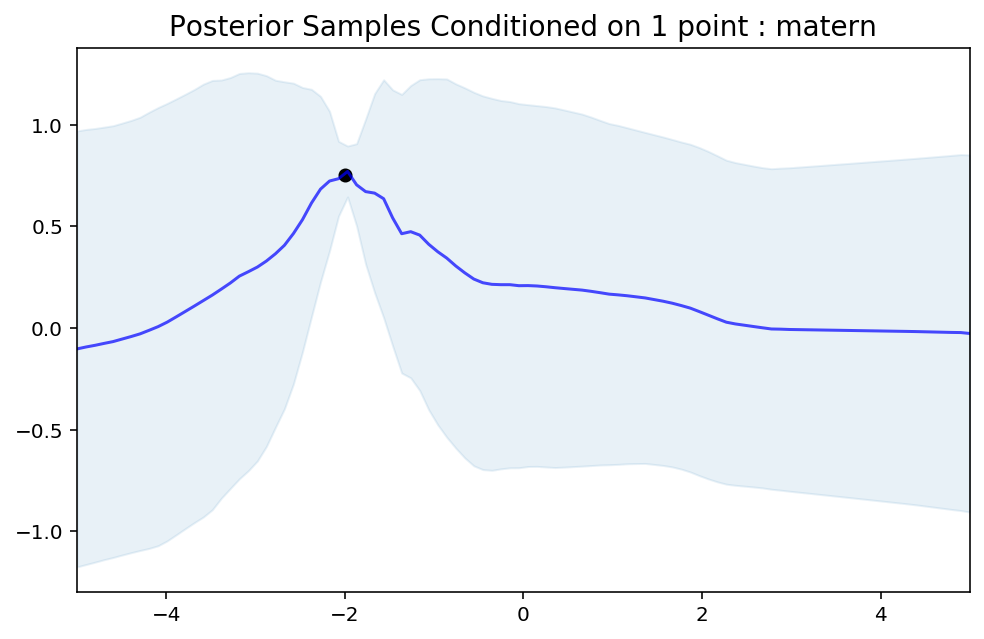

In [11]:
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(neural_proc, torch.tensor([[[-2.]]]), torch.tensor([[[0.75]]]), 
                           is_plot_std=True, n_samples=1,
                           title="Posterior Samples Conditioned on 1 point : {}".format(k))